In [1]:
# from http://scikit-learn.org/stable/auto_examples/decomposition/plot_image_denoising.html

In [2]:
from time import time

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

from sklearn.decomposition import FastICA
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.feature_extraction.image import reconstruct_from_patches_2d
from sklearn.utils.testing import SkipTest
from sklearn.utils.fixes import sp_version

if sp_version < (0, 12):
    raise SkipTest("Skipping because SciPy version earlier than 0.12.0 and "
                   "thus does not include the scipy.misc.face() image.")
    
%matplotlib inline

In [3]:
try:
    from scipy import misc
    face = misc.face(gray=True)
except AttributeError:
    # Old versions of scipy have face in the top level package
    face = sp.face(gray=True)

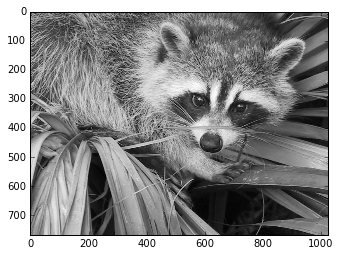

In [4]:
plt.imshow(face, cmap="gray")

In [5]:
# Convert from uint8 representation with values between 0 and 255 to
# a floating point representation with values between 0 and 1.
face = face / 255.0

In [6]:
# downsample for higher speed
face = face[::2, ::2] + face[1::2, ::2] + face[::2, 1::2] + face[1::2, 1::2]
face /= 4.0
height, width = face.shape

In [7]:
# Distort the right half of the image
print('Distorting image...')
distorted = face.copy()
distorted[:, width // 2:] += 0.075 * np.random.randn(height, width // 2)

Distorting image...


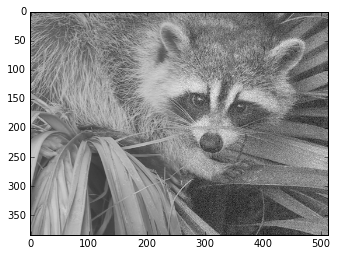

In [8]:
plt.imshow(distorted, cmap="gray")

In [9]:
# Extract all reference patches from the left half of the image
print('Extracting reference patches...')
t0 = time()
patch_size = (7, 7)
data = extract_patches_2d(distorted[:, :width // 2], patch_size)
data = data.reshape(data.shape[0], -1)
data -= np.mean(data, axis=0)
#data /= np.std(data, axis=0)
print('done in %.2fs.' % (time() - t0))

Extracting reference patches...
done in 0.04s.


In [10]:
# Learn from reference patches
print('Learning...')
nc=20
t0 = time()
dico = FastICA(n_components=nc, max_iter=2000, tol=1e-4)
V = dico.fit(data).components_
dt = time() - t0
print('done in %.2fs.' % dt)

Learning...
done in 3.46s.


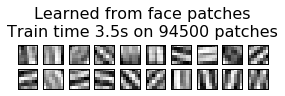

In [11]:
plt.figure(figsize=(4.2, 4))
for i, comp in enumerate(V[:100]):
    plt.subplot(10, 10, i + 1)
    plt.imshow(comp.reshape(patch_size), cmap=plt.cm.gray_r,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
plt.suptitle('Learned from face patches\n' +
             'Train time %.1fs on %d patches' % (dt, len(data)),
             fontsize=16)
plt.subplots_adjust(0.08, 0.02, 0.92, 0.85, 0.08, 0.23)

In [12]:
def norm2(myvec):
    return np.sum(np.square(myvec))

In [13]:
for i, comp in enumerate(V[:100]):
    print norm2(comp)

0.000248736855654
0.000610163592669
0.00103721550613
0.00115520133694
0.000228210451428
3.3274860619e-05
0.00122018327648
0.000777749873344
0.000533450463275
0.00124503839206
0.00100723152667
0.00102605840587
0.00105449255586
0.00123157400375
0.00103573744588
0.00129383626998
0.000717838637218
0.000929428524928
0.000992823872947
0.00143064728974


In [14]:
# Display the distorted image

def show_with_diff(image, reference, title):
    """Helper function to display denoising"""
    plt.figure(figsize=(10, 7))
    plt.subplot(1, 2, 1)
    plt.title('Image')
    plt.imshow(image, vmin=0, vmax=1, cmap=plt.cm.gray,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.subplot(1, 2, 2)
    difference = image - reference

    plt.title('Difference (norm: %.2f)' % np.sqrt(np.sum(difference ** 2)))
    plt.imshow(difference, vmin=-0.5, vmax=0.5, cmap=plt.cm.PuOr,
               interpolation='nearest')
    plt.xticks(())
    plt.yticks(())
    plt.suptitle(title, size=16)
    #plt.subplots_adjust(0.02, 0.02, 0.98, 0.79, 0.02, 0.2)

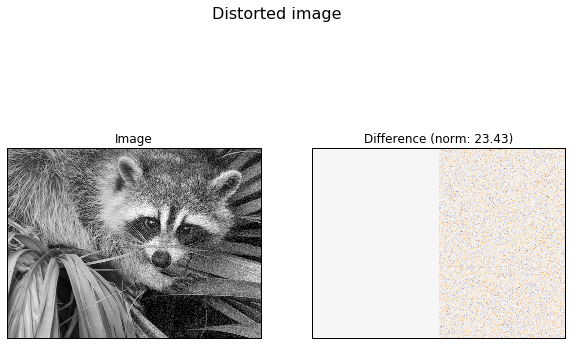

In [15]:
show_with_diff(distorted, face, 'Distorted image')

Extract noisy patches and reconstruct them using the dictionary

In [16]:
print('Extracting noisy patches... ')
t0 = time()
data = extract_patches_2d(distorted[:, width // 2:], patch_size)
data = data.reshape(data.shape[0], -1)
intercept = np.mean(data, axis=0)
data -= intercept
print('done in %.2fs.' % (time() - t0))

Extracting noisy patches... 
done in 0.04s.


In [17]:
transform_algorithms = [
    ('ICA\n', 'omp',
     {'components': nc})]

ICA
...
done in 0.84s.


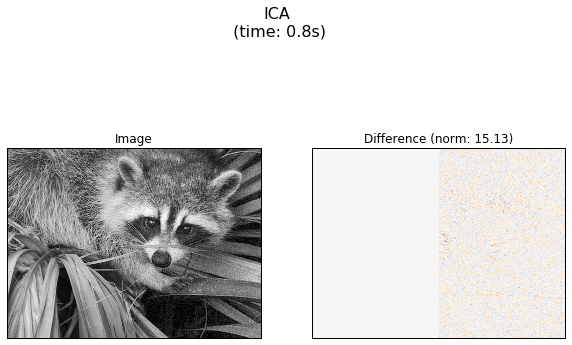

In [18]:
reconstructions = {}
for title, transform_algorithm, kwargs in transform_algorithms:
    print(title + '...')
    reconstructions[title] = face.copy()
    t0 = time()
    #dico.set_params(transform_algorithm=transform_algorithm, **kwargs)
    code = dico.transform(data)
    #patches = np.dot(code, V)
    patches = dico.inverse_transform(code)
    
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()

    patches += intercept
    patches = patches.reshape(len(data), *patch_size)
    if transform_algorithm == 'threshold':
        patches -= patches.min()
        patches /= patches.max()
    reconstructions[title][:, width // 2:] = reconstruct_from_patches_2d(
        patches, (height, width // 2))
    dt = time() - t0
    print('done in %.2fs.' % dt)
    show_with_diff(reconstructions[title], face,
                   title + ' (time: %.1fs)' % dt)

plt.show()